[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/okada-tak/deep-learning-from-scratch-2/blob/master/notebooks/ch03.ipynb)

# 3章 word2vec のまとめ
- 推論ベースの手法は、推測することを目標として、その副産物として単語の分散表現を得られる
- word2vecは推論ベースの手法であり、シンプルな2層のニューラルネットワークで構成される
- word2vecには、skip-gramモデルとCBOWモデルがある
- CBOWモデルは複数の単語（コンテキスト）からひとつの単語（ターゲット）を推測する
- skip-gramモデルは逆に、ひとつの単語（ターゲット）から複数の単語（コンテキスト）を推測する
- word2vecは重みの再学習ができるため、単語の分散表現の更新や追加が効率的に行える

## 3.1 推論ベースの手法とニューラルネットワーク
### 3.1.1 カウントベースの手法の問題点
- 語彙数が巨大
- 巨大な行列に対してSVD(特異値分解)を行うのは計算量が膨大で非現実的

### 3.1.2 推論ベースの手法の概要
- モデルはコンテキスト情報を入力として受け取り、各単語の出現する確率を出力する
- 正しい推測ができるように、コーパスを使ってモデルの学習を行う
- その学習の結果として、単語の分散表現を得られる

### 3.1.3 ニューラルネットワークにおける単語の処理方法


In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) # 入力
W = np.random.rand(7,3) # 重み
h = np.dot(c, W) # 中間ノード：ノード数3
print(h)

[[0.30453593 0.30696176 0.7327011 ]]


## ■Colaboratory用
Google Colaboratoryの場合、Google Driveに  
dl-from-scratch-2/ch03  
というフォルダを用意し、そこにこのjupyter notebookを配置。  
(dl-from-scratch-3の部分は任意。)  
また、datasetフォルダとcommonフォルダを
dl-from-scratch-3/dataset  
dl-from-scratch-3/common
にコピーしておく。  

以下のセルでGoogle Driveをマウント。許可を求められるので許可する。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ■Colaboratory用
chdirする。

In [3]:
import sys,os
os.chdir('/content/drive/My Drive/dl-from-scratch-2/ch03')
os.getcwd()

'/content/drive/My Drive/dl-from-scratch-2/ch03'

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 0.18413677 -1.50021101 -1.44694449]]


## 3.2 シンプルなword2vec
### 3.2.1 CBOWモデルの推論処理
CBOW: continuous bag-of-words  
ターゲットは中央の単語、その周囲の単語がコンテキスト  
$\text{W}_{\text{in}}$が重みの行列であり、その各行が各単語の分散表現  



ch03/cbow_predict.py

In [5]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[ 0.16910649  1.05322591  0.48877746 -0.52625989  0.57784509  1.11857825
  -0.01229624]]


### 3.2.2 CBOWモデルの学習
多クラス分類なので、Softmaxと交差エントロピー誤差を使う

### 3.2.3 word2vecの重みと分散表現
$\text{W}_{\text{out}}$も重みの行列であり、その各列が各単語の分散表現  
word2vecの特にskip-gramモデルでは入力側の重みだけを利用するのが多い

## 3.3 学習データの準備
### 3.3.1 コンテキストとターゲット


In [6]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [7]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


common/uitl.py

In [8]:
def create_contexts_target(corpus, window_size=1):
    '''コンテキストとターゲットの作成

    :param corpus: コーパス（単語IDのリスト）
    :param window_size: ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [9]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [10]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 one-hot表現への変換

In [11]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## 3.4 CBOWモデルの実装

ch03/simple_cbow.py

In [12]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 学習コードの実装

ch03/train.py

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

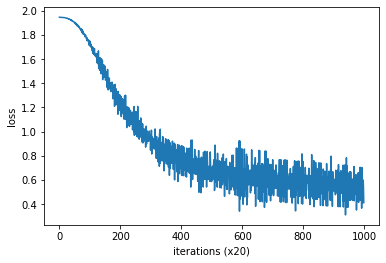

In [13]:
# coding: utf-8
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [14]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.0819478 -1.0026096  0.652681  -1.3337427  1.3039364]
say [-1.1728728  1.135156  -1.1602501 -0.2634322  0.0869044]
goodbye [ 0.66276157 -0.8006624   1.1063087  -0.6900885   0.59174055]
and [-1.0061218   0.98702526 -1.012091    1.6386914   1.6862429 ]
i [ 0.6755251  -0.8336841   1.1335676  -0.69021463  0.6006586 ]
hello [ 1.078029   -1.0008671   0.66804737 -1.3025002   1.3107113 ]
. [-0.96835786  0.96727276 -0.9724375  -1.4642186  -1.3796707 ]


## 3.5 word2vecに関する補足
### 3.5.1 CBOWモデルと確率
$$
P(w_t|w_{t-1},w_{t+1})
$$
負の対数尤度(negative log likelihood)  
1つのサンプルデータに関する損失関数
$$
L=-logP(w_t|w_{t-1},w_{t+1})
$$
コーパス全体の損失関数
$$
L=-\frac{1}{T}\displaystyle \sum_{i=1}^TlogP(w_t|w_{t-1},w_{t+1})
$$

### 3.5.2 skip-gramモデル
$$
P(w_{t-1},w_{t+1}|w_t)
$$

$$
P(w_{t-1},w_{t+1}|w_t)=P(w_{t-1}|w_t)P(w_{t+1}|w_t)
$$

1つのサンプルデータに関する損失関数
$$
\begin{split}
L&=-logP(w_{t-1},w_{t+1}|w_t)\\  
&=-logP(w_{t-1}|w_t)P(w_{t+1}|w_t)\\  
&=-(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t))
\end{split}
$$

コーパス全体の損失関数
$$
L=-\frac{1}{T}\displaystyle \sum_{i=1}^T(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t))
$$

ch03/simple_skip_gram.py

In [15]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None